In [ ]:
try:
    import Image
except ImportError:
    from PIL import Image

import os
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout,Add, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'CENG501 Whole Materials.gdoc'
 dataset
 dataset1
'FCN_Implementation of ISIC_2016.ipynb'
 FCN_ISIC2016.ipynb
 Im_Writing
 ISBI2016_ISIC_Part1_Test_Data
 ISBI2016_ISIC_Part1_Test_Data.zip
 ISBI2016_ISIC_Part1_Test_GroundTruth
 ISBI2016_ISIC_Part1_Test_GroundTruth.zip
 ISBI2016_ISIC_Part1_Training_Data
 ISBI2016_ISIC_Part1_Training_Data.zip
 ISBI2016_ISIC_Part1_Training_GroundTruth
 ISBI2016_ISIC_Part1_Training_GroundTruth.zip
 PA1_my_answers
 unet.h5
 vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
#İlayda 
import os
os.chdir("/content/drive/MyDrive/CENG501/")
!ls

'CENG501 Whole Materials.gdoc'
 dataset
 dataset1
'FCN_Implementation of ISIC_2016.ipynb'
 FCN_ISIC2016.ipynb
 Im_Writing
 ISBI2016_ISIC_Part1_Test_Data
 ISBI2016_ISIC_Part1_Test_Data.zip
 ISBI2016_ISIC_Part1_Test_GroundTruth
 ISBI2016_ISIC_Part1_Test_GroundTruth.zip
 ISBI2016_ISIC_Part1_Training_Data
 ISBI2016_ISIC_Part1_Training_Data.zip
 ISBI2016_ISIC_Part1_Training_GroundTruth
 ISBI2016_ISIC_Part1_Training_GroundTruth.zip
 PA1_my_answers
 unet.h5
 vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
!pwd

/content/drive/MyDrive/CENG501


In [37]:
dir_data = "dataset"
dir_seg_train = dir_data + "/train_segmentation/"
dir_img_train = dir_data + "/train_images/"
dir_seg_test = dir_data + "/test_segmentation/"
dir_img_test = dir_data + "/test_images/"
image_writing_folder="Im_Writing/"
VGG_Weights_path ="vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

ISIC_0000000_Segmentation.png
ISIC_0000000.jpg


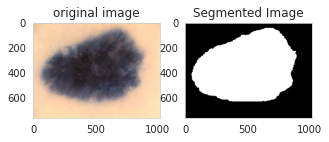

In [38]:
## seaborn has white grid by default so I will get rid of this.
sns.set_style("whitegrid", {'axes.grid' : False})


ldval = np.array(sorted(os.listdir(dir_seg_train)))
ldimg=np.array(sorted(os.listdir(dir_img_train)))
## pick the first image file
fnm = ldval[0]
fnm2= ldimg[0]
print(fnm)
print(fnm2)

## read in the original image and segmentation labels
seg = cv2.imread(dir_seg_train +  fnm) # (360, 480, 3)
#seg[seg == 255] = 1
#seg=cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)
#(thresh, seg) = cv2.threshold(seg, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

img_is= cv2.imread(dir_img_train + fnm2 )

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(img_is)
ax.set_title("original image")

ax = fig.add_subplot(1,2,2)
ax.imshow(seg)
ax.set_title("Segmented Image")
plt.show()



In [39]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
	while True: 

		#extract a random batch 
		batch = np.random.choice(files, size = batch_size)    
		# print('batch: ' + str(batch))
		#variables for collecting batches of inputs and outputs 
		batch_x = []
		batch_y = []

		for f in batch:

			#get the masks. Note that masks are png files 
			mask = Image.open(dir_seg_train + f )
			plt.imsave(image_writing_folder + 'mask.png', mask)
			mask = np.array(mask.resize(sz))
			# print(mask[mask>0])

			#preprocess the mask 
			# mask[mask > 2] = 0 
			mask[mask != 0 ] = 1
			plt.imsave(image_writing_folder + 'mask2.png', mask)

			batch_y.append(mask)

			#preprocess the raw images 
			raw = Image.open(dir_img_train + f'{f[:-17]}.jpg')
			# print(isbi2016_training_path + f'{f[:-17]}.jpg')
			raw = raw.resize(sz)
			raw = np.array(raw)

			#check the number of channels because some of the images are RGBA or GRAY
			if len(raw.shape) == 2:
			  raw = np.stack((raw,)*3, axis=-1)

			else:
			  raw = raw[:,:,0:3]

			batch_x.append(raw)

		#preprocess a batch of images and masks 
		batch_x = np.array(batch_x)/255.
		batch_y = np.array(batch_y)
		batch_y = np.expand_dims(batch_y,3)

		yield (batch_x, batch_y)




['ISIC_0000021_Segmentation.png', 'ISIC_0000045_Segmentation.png', 'ISIC_0000114_Segmentation.png', 'ISIC_0000075_Segmentation.png', 'ISIC_0000078_Segmentation.png']


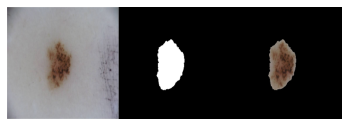

In [40]:
batch_size = 1

all_files = os.listdir(dir_seg_train)
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]
print(test_files)

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

x, y= next(train_generator)

plt.axis('off')
img = x[0]
msk = y[0].squeeze()
msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))
plt.imsave(image_writing_folder + 'file.jpg', np.concatenate([img, msk, img*msk], axis = 1))



In [42]:
# metrikler burda

def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou


In [43]:
# model 

def FCN8( input_height=256,
          input_width=256, channels=3):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    nClasses=2
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)   
    # assuming that the input_height = input_width = 224 as in VGG data
    
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
    
    
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    
    model = Model(img_input, o)

    return model

model = FCN8()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [44]:
# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
	def on_train_begin(self, logs={}):
		print("train started")
		self.i = 0
		self.x = []
		self.losses = []
		self.val_losses = []
		self.acc = []
		self.val_acc = []
		#self.fig = plt.figure()
		self.logs = []
	def on_epoch_end(self, epoch, logs={}):
		self.logs.append(logs)
		self.x.append(self.i)
		self.losses.append(logs.get('loss'))
		self.val_losses.append(logs.get('val_loss'))
		self.acc.append(logs.get('mean_iou'))
		self.val_acc.append(logs.get('val_mean_iou'))
		self.i += 1
		print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))

		#choose a random test image and preprocess
		f = np.random.choice(test_files)
		raw = Image.open(dir_img_train + f'{f[:-17]}.jpg')
		raw = np.array(raw.resize((256, 256)))/255.
		raw = raw[:,:,0:3]

		#predict the mask 
		pred = model.predict(np.expand_dims(raw, 0))

		#mask post-processing 
		msk  = pred.squeeze()
		msk = np.stack((msk,)*3, axis=-1)
		msk[msk >= 0.5] = 1 
		msk[msk < 0.5] = 0 

		#show the mask and the segmented image 
		combined = np.concatenate([raw, msk, raw* msk], axis = 1)
		plt.axis('off')
		plt.imshow(combined)
		plt.show()



In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
from tensorflow.keras import optimizers

# DENIS COMMENT: 
#Use without decay (1) decay
# Try another comparing with another optimizer e.g adam
# use epoch in the order of 100 > 200 > 500 >1000
sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
model.fit(x = train_generator, validation_data = test_generator, epochs = 1, batch_size=64
	 ,verbose = 2)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# prediction burda başlıyor

any_test_image = dir_img_test + "ISIC_0000003.jpg"


raw = Image.open(any_test_image)
raw = np.array(raw.resize((256, 256)))/255.
raw = raw[:,:,0:3]

#predict the mask 
pred = model.predict(np.expand_dims(raw, 0))

#mask post-processing 
msk  = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

#show the mask and the segmented image 
combined = np.concatenate([raw, msk, raw* msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()
